# Sprint クロスバリデーション　スクラッチ

## 【問題1】クロスバリデーション

事前学習期間では検証用データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

sklearn.model_selection.KFold — scikit-learn 0.21.3 documentation

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [81]:
df = pd.read_csv('application_train.csv')#教師データを読み込む

pd.set_option('display.max_columns', 250)
np.set_printoptions(threshold=np.inf)

#application_test = pd.read_csv("application_test.csv")

In [82]:
# objectの欠損値をmodeで、int,floatの欠損値をmeanで置換。mode()後の[0]に注意。
df_object = df.select_dtypes(include = "object")
for column in df_object.columns:
    df[column] = df_object[column].fillna(df_object[column].mode()[0])
df_int_float = df.select_dtypes(exclude = "object")
for column in df_int_float.columns:
    df[column] = df_int_float[column].fillna(df_int_float[column].mean())
    
# 欠損値が全て穴埋めされた確認。
df.isnull().sum().sum()

0

In [83]:
### ダミー処理 ###
print(df.shape)
df_onehot = df
for column in df_object.columns:
    df_onehot = pd.concat([df_onehot, pd.get_dummies(df[column])],axis=1)

print(df_onehot.shape)
for column in df_object.columns:
    df_onehot = df_onehot.drop(column, axis=1)

print(df_onehot.shape)

(307511, 122)
(307511, 262)
(307511, 246)


In [84]:
###　特徴量選択　###
df_onehot=df_onehot[['LIVINGAREA_MODE', 'Secondary / secondary special',
       'YEARS_BEGINEXPLUATATION_MODE', 'COMMONAREA_MODE', 'TOTALAREA_MODE',
       'M', 'OWN_CAR_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'HOUR_APPR_PROCESS_START', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'AMT_ANNUITY',
       'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_BIRTH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3']]

#        'Married', 'NONLIVINGAREA_MEDI', 'TUESDAY',
#        'CNT_CHILDREN', 'NONLIVINGAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MODE',
#        'LANDAREA_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE', 'LIVINGAPARTMENTS_MODE',
#        'DEF_30_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_MEDI',
#        'YEARS_BEGINEXPLUATATION_AVG', 'FLAG_DOCUMENT_3',
#        'LIVINGAPARTMENTS_AVG', 'CNT_FAM_MEMBERS', 'LIVINGAREA_MEDI',
#        'OBS_30_CNT_SOCIAL_CIRCLE', 'YEARS_BUILD_MEDI', 'LIVINGAREA_AVG',
#        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
#        'REG_CITY_NOT_LIVE_CITY', 'Managers', 'ENTRANCES_MODE',
#        'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT',
#        'REGION_RATING_CLIENT', 'AMT_REQ_CREDIT_BUREAU_MON', 'THURSDAY',
#        'ENTRANCES_AVG', 'BASEMENTAREA_MODE', 'Higher education', 'Working',
#        'Commercial associate', 'F', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
#        'FLOORSMAX_MODE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'ENTRANCES_MEDI',
#        'APARTMENTS_MODE',


In [85]:
### 特徴量の追加 ###
df_onehot["CREDIT/INCOME"] = df_onehot["AMT_CREDIT"]/df_onehot["AMT_INCOME_TOTAL"]
df_onehot["CREDIT/GOODS"] = df_onehot["AMT_CREDIT"]/df_onehot["AMT_GOODS_PRICE"]

In [7]:
## cross validation
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
X = df_onehot.values
y = df.TARGET.values

clf = RandomForestClassifier(random_state = 30 )
kf = KFold(n_splits=5, random_state= 1, shuffle=True)

scores = cross_val_score(clf, X, y, cv=kf, n_jobs = -1)
print(scores)
print(scores.mean())

[0.91798774 0.91793763 0.91901076 0.91601899 0.91954733]
0.918100491080809


In [9]:
##　stratified kfoldのcross validation
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
scores = cross_val_score(clf, X, y, cv=skf, n_jobs = -1)
print(scores)
print(scores.mean())

[0.91782515 0.91816526 0.91748236 0.91797015 0.91785633]
0.9178598490288227


In [8]:
##　stratified kfoldのcross validation (roc_auc)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
scores = cross_val_score(clf, X, y, cv=skf, n_jobs = -1, scoring = "roc_auc")
print(scores)
print(scores.mean())

[0.64388682 0.64974486 0.64855141 0.646142   0.65127444]
0.6479199055125682


## 【問題2】グリッドサーチ

　これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。  
　  
scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。  
　  
sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation　  
　  
GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [21]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[70],
          "max_depth": [10, 20, 30]       
         }
    
#    'max_depth': list(range(4, 10)),
#    'min_samples_split': [2,4,6],
#    'criterion': ['gini', 'entropy'],


grid_search = GridSearchCV(clf,  # 分類器を渡す
                           param_grid=params,  # 試行してほしいパラメータを渡す
                           cv=5,  # 5-Fold CV で汎化性能を調べる
                           scoring = "roc_auc"
                           )

# グリッドサーチで優れたハイパーパラメータを探す
grid_search.fit(X, y)

print(grid_search.best_score_)  # 最も良かったスコア
print(grid_search.best_params_)  # 上記を記録したパラメータの組み合わせ

display(pd.DataFrame(grid_search.cv_results_))


0.7436332745122856
{'max_depth': 10, 'n_estimators': 70}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,72.799371,9.795673,0.855188,0.239744,10,70,"{'max_depth': 10, 'n_estimators': 70}",0.743285,0.744097,0.739750,0.745442,0.745592,0.743633,0.002122,1
1,132.309159,5.073169,1.830294,0.498631,20,70,"{'max_depth': 20, 'n_estimators': 70}",0.727933,0.728724,0.722636,0.728795,0.726022,0.726822,0.002320,2
2,129.590586,12.245406,1.965022,0.685651,30,70,"{'max_depth': 30, 'n_estimators': 70}",0.715498,0.714975,0.709829,0.712103,0.712340,0.712949,0.002070,3


計算時間がかかるので、n_estimators は個別に実行した（他の変数は一定）。  
n_estimators = 30 では、roc_aucが0.6897となり、  
n_estimators = 50～100では、roc_aucが0.71となった。  
（n_estimators = 75、100では、roc_aucが0.7115、0.7158だった）。  
したがって、グリッドサーチにより、{'max_depth': 10, 'n_estimators': 70}とする。

## 【問題3】Kernelからの調査

・LightGBMによる計算が良いようだ。特徴量を増やしても計算速度が致命的な副作用は少ないようだが、無差別に採用するのはよくないようだ。  
<br>
・ハイパーパラメータの調整よりも特徴量エンジニアリングを重視すべきのようだ。特徴量エンジニアリングでは、カラム同士の演算、min,max,mean,var,countなどを用いた集計は多くの方がやっており、ターゲットエンコーディングなども有望そうだ。  
<br>
・クロスバリデーションによる汎化性能は、コンペにおいては極めて重要であるということだ。モデルの乱数seedを変えるとスコアが結構変わることもあるらしく、ひとまずStratifiedKFold(k=5)を用いている。  
　  
・StratifiedKFold(層化抽出法）を使うと、サブセットを作るときに目的変数の比率がなるべく元のままになるように分割できる。  
<br>
・今回のデータには、時系列性が内包されているらしくクロスバリデーションのスコアとＬＢのスコアがぶれてしまうという問題があるようだ。（時系列性を取り除くのは、application_csv以外のファイルの検証をする必要がありそうだ）。なお１位のカーネルでは、時系列性に着目したラグ特徴量を使用しているようだ。  
<br>
・特徴量を新しく作成する時には、クロスバリデーションの際の計算速度を向上させて早く回す必要があるため、新たな特徴料以外の特徴量を少なめに選別して試行錯誤すると良い。  


## 【問題4】高い汎化性能のモデル作成

ＬＧＢＭとstratifiedkfoldを使ってみる。特徴量エンジニアリングは既にある程度は実行しているので、ハイパーパラメータの検討を行ってみる。  

Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.256476	valid_1's binary_logloss: 0.256656
[20]	training's binary_logloss: 0.249864	valid_1's binary_logloss: 0.250693
[30]	training's binary_logloss: 0.246534	valid_1's binary_logloss: 0.248259
[40]	training's binary_logloss: 0.244372	valid_1's binary_logloss: 0.247108
[50]	training's binary_logloss: 0.242589	valid_1's binary_logloss: 0.246297
[60]	training's binary_logloss: 0.241074	valid_1's binary_logloss: 0.245795
[70]	training's binary_logloss: 0.239636	valid_1's binary_logloss: 0.245536
[80]	training's binary_logloss: 0.23838	valid_1's binary_logloss: 0.245446
[90]	training's binary_logloss: 0.237212	valid_1's binary_logloss: 0.245322
[100]	training's binary_logloss: 0.236166	valid_1's binary_logloss: 0.245298
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.236166	valid_1's binary_logloss: 0.245298
ROC_AUC:0.7617061433216424
0.06767633539585213
Trainin

(array([4.0406e+04, 1.2300e+04, 4.8300e+03, 2.1040e+03, 1.0100e+03,
        4.9200e+02, 2.1300e+02, 1.0600e+02, 3.5000e+01, 6.0000e+00]),
 array([0.00719798, 0.07798408, 0.14877018, 0.21955629, 0.29034239,
        0.36112849, 0.43191459, 0.5027007 , 0.5734868 , 0.6442729 ,
        0.71505901]),
 <a list of 10 Patch objects>)

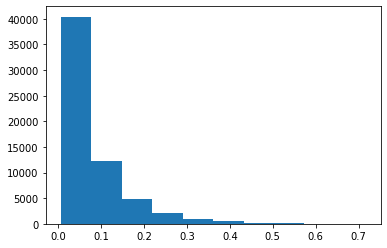

In [15]:
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = df_onehot.values
y = df.TARGET.values


params = {
    'objective': 'binary',      # ２値分類
    'max_depth': 10,            # 木の深さ
    'learning_rate':0.1,         # 学習率
    'num_class': 1,
    'verbose': 10    
}

#評価値を平均化するためのリスト
scores = []

for t_index, v_index in kf.split(X):
    X_train, y_train = X[t_index], y[t_index]
    X_eval, y_eval = X[v_index],y[v_index]
    
    train_data = lgbm.Dataset(X_train, y_train)
    eval_data = lgbm.Dataset(X_eval, y_eval)
    
    clf = lgbm.train(params=params,
                      train_set=train_data,
                      valid_sets=[train_data, eval_data],
                      early_stopping_rounds=20,
                      verbose_eval=10)

    y_pred = clf.predict(X_eval)
    mse_score = mean_squared_error(y_eval, y_pred)
    print("ROC_AUC:{}".format(roc_auc_score(y_eval, y_pred)))
    scores.append(roc_auc_score(y_eval, y_pred))                             # 評価値を平均化するため,リストに追加していく
    print(mse_score)

print("ROC_AUC:{}".format(scores))
plt.hist(y_pred)

## LGBMを使うことで、ROC_AUCが0.75～0.76ぐらいに向上した。

### ＬＧＢＭのハイパーパラメータをＯＰＴＵＮＡを使って探索してみる。

参考：　https://www.codexa.net/lightgbm-beginner/  

In [17]:
import optuna

In [34]:
def objective(trial):
    
    params = {
        'objective': 'binary',      # ２値分類
        'max_depth': trial.suggest_int('max_depth', 2, 200),            # 木の深さ
        'learning_rate':trial.suggest_uniform('learning_rate', 0.1, 0.5),        # 学習率
        'num_class': 1,
        
        'num_leaves': trial.suggest_int('num_leaves', 2, 200),            # LightGBMで最も重要。決定木の複雑度を調整します。
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 200),            # 決定木のノード（葉）の最小データ数を指定
       
#         'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.0, 1.0),
#         'lambda_l1' : trial.suggest_uniform('lambda_l1' , 0.0, 1.0),
#         'lambda_l2' : trial.suggest_uniform('lambda_l2' , 0.0, 1.0)
    }
              
    
    #評価値を平均化するためのリスト
    scores = []

    for t_index, v_index in kf.split(X):
        X_train, y_train = X[t_index], y[t_index]
        X_eval, y_eval = X[v_index],y[v_index]

        train_data = lgbm.Dataset(X_train, y_train)
        eval_data = lgbm.Dataset(X_eval, y_eval)

        clf = lgbm.train(params=params,
                         train_set=train_data,
                         valid_sets=[train_data, eval_data],
                         early_stopping_rounds=20,
                         verbose_eval=10)

        y_pred = clf.predict(X_eval)
        score = roc_auc_score(y_eval, y_pred)
        scores.append(score)                             # 評価値を平均化するため,リストに追加していく
    
    return np.mean(scores) # この評価値を良くするために、optuna は頑張ってくれる

In [35]:
# optuna でハイパーパラメータの最適化
study = optuna.create_study()
study.optimize(objective, n_trials=10, timeout=180) # n_trials を大きくすると、チューニング回数がたくさん出来るかわりに遅くなる

Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.239529	valid_1's binary_logloss: 0.24992
[20]	training's binary_logloss: 0.230688	valid_1's binary_logloss: 0.251176
[30]	training's binary_logloss: 0.22254	valid_1's binary_logloss: 0.252491
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.238457	valid_1's binary_logloss: 0.249911
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.239167	valid_1's binary_logloss: 0.252251
[20]	training's binary_logloss: 0.229745	valid_1's binary_logloss: 0.252929
[30]	training's binary_logloss: 0.222431	valid_1's binary_logloss: 0.254629
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.236774	valid_1's binary_logloss: 0.251809
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.239367	valid_1's binary_logloss: 0.249826
[20]	training's binary_logloss: 0.230346	valid_1's binary_logloss

[I 2020-04-11 17:36:18,589] Finished trial#0 resulted in value: 0.7436878916258918. Current best value is 0.7436878916258918 with parameters: {'max_depth': 127, 'learning_rate': 0.44605842066873047, 'num_leaves': 72, 'min_data_in_leaf': 136}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.238077	valid_1's binary_logloss: 0.251391
[20]	training's binary_logloss: 0.227845	valid_1's binary_logloss: 0.253547
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.240606	valid_1's binary_logloss: 0.251338
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.237322	valid_1's binary_logloss: 0.253244
[20]	training's binary_logloss: 0.226972	valid_1's binary_logloss: 0.255782
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.241231	valid_1's binary_logloss: 0.252904
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.237897	valid_1's binary_logloss: 0.251144
[20]	training's binary_logloss: 0.227825	valid_1's binary_logloss: 0.253606
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.243449	valid_1's binary_logloss: 0.251078
Training until validation score

[I 2020-04-11 17:36:27,467] Finished trial#1 resulted in value: 0.7392466441589388. Current best value is 0.7392466441589388 with parameters: {'max_depth': 55, 'learning_rate': 0.46107053431365763, 'num_leaves': 80, 'min_data_in_leaf': 83}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.237574	valid_1's binary_logloss: 0.248691
[20]	training's binary_logloss: 0.226493	valid_1's binary_logloss: 0.248294
[30]	training's binary_logloss: 0.2179	valid_1's binary_logloss: 0.248733
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.231471	valid_1's binary_logloss: 0.24797
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.237132	valid_1's binary_logloss: 0.250528
[20]	training's binary_logloss: 0.225536	valid_1's binary_logloss: 0.249997
[30]	training's binary_logloss: 0.216905	valid_1's binary_logloss: 0.251592
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.231826	valid_1's binary_logloss: 0.249641
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.237692	valid_1's binary_logloss: 0.248947
[20]	training's binary_logloss: 0.22649	valid_1's binary_logloss: 

[I 2020-04-11 17:36:39,007] Finished trial#2 resulted in value: 0.7457133367402747. Current best value is 0.7392466441589388 with parameters: {'max_depth': 55, 'learning_rate': 0.46107053431365763, 'num_leaves': 80, 'min_data_in_leaf': 83}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.241111	valid_1's binary_logloss: 0.250852
[20]	training's binary_logloss: 0.229285	valid_1's binary_logloss: 0.248016
[30]	training's binary_logloss: 0.220247	valid_1's binary_logloss: 0.24761
[40]	training's binary_logloss: 0.21253	valid_1's binary_logloss: 0.247726
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.224519	valid_1's binary_logloss: 0.247505
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.240677	valid_1's binary_logloss: 0.252475
[20]	training's binary_logloss: 0.228928	valid_1's binary_logloss: 0.250092
[30]	training's binary_logloss: 0.219788	valid_1's binary_logloss: 0.249756
[40]	training's binary_logloss: 0.212129	valid_1's binary_logloss: 0.250272
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.220617	valid_1's binary_logloss: 0.249656
Training until validation scores don't improve for

[I 2020-04-11 17:36:53,107] Finished trial#3 resulted in value: 0.7478728553974365. Current best value is 0.7392466441589388 with parameters: {'max_depth': 55, 'learning_rate': 0.46107053431365763, 'num_leaves': 80, 'min_data_in_leaf': 83}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.236531	valid_1's binary_logloss: 0.249761
[20]	training's binary_logloss: 0.224519	valid_1's binary_logloss: 0.250034
[30]	training's binary_logloss: 0.214977	valid_1's binary_logloss: 0.251681
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.229912	valid_1's binary_logloss: 0.249475
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.236057	valid_1's binary_logloss: 0.25183
[20]	training's binary_logloss: 0.223797	valid_1's binary_logloss: 0.25311
[30]	training's binary_logloss: 0.214214	valid_1's binary_logloss: 0.254804
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.234613	valid_1's binary_logloss: 0.251754
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.236625	valid_1's binary_logloss: 0.249931
[20]	training's binary_logloss: 0.224182	valid_1's binary_logloss

[I 2020-04-11 17:37:03,601] Finished trial#4 resulted in value: 0.7430934545180128. Current best value is 0.7392466441589388 with parameters: {'max_depth': 55, 'learning_rate': 0.46107053431365763, 'num_leaves': 80, 'min_data_in_leaf': 83}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.24081	valid_1's binary_logloss: 0.248983
[20]	training's binary_logloss: 0.232431	valid_1's binary_logloss: 0.249131
[30]	training's binary_logloss: 0.225932	valid_1's binary_logloss: 0.250537
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.237807	valid_1's binary_logloss: 0.248444
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.240714	valid_1's binary_logloss: 0.251207
[20]	training's binary_logloss: 0.232362	valid_1's binary_logloss: 0.251707
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.241734	valid_1's binary_logloss: 0.251064
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.240896	valid_1's binary_logloss: 0.249118
[20]	training's binary_logloss: 0.232957	valid_1's binary_logloss: 0.249923
[30]	training's binary_logloss: 0.226397	valid_1's binary_logloss

[I 2020-04-11 17:37:12,089] Finished trial#5 resulted in value: 0.7451478233890152. Current best value is 0.7392466441589388 with parameters: {'max_depth': 55, 'learning_rate': 0.46107053431365763, 'num_leaves': 80, 'min_data_in_leaf': 83}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.22639	valid_1's binary_logloss: 0.255551
[20]	training's binary_logloss: 0.207232	valid_1's binary_logloss: 0.259656
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.23591	valid_1's binary_logloss: 0.25385
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.225998	valid_1's binary_logloss: 0.256369
[20]	training's binary_logloss: 0.206182	valid_1's binary_logloss: 0.260366
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.238239	valid_1's binary_logloss: 0.254958
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.225895	valid_1's binary_logloss: 0.255053
[20]	training's binary_logloss: 0.206767	valid_1's binary_logloss: 0.260991
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.235748	valid_1's binary_logloss: 0.253666
Training until validation scores d

[I 2020-04-11 17:37:21,832] Finished trial#6 resulted in value: 0.7337552700407296. Current best value is 0.7337552700407296 with parameters: {'max_depth': 165, 'learning_rate': 0.4079732990955779, 'num_leaves': 174, 'min_data_in_leaf': 45}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244553	valid_1's binary_logloss: 0.248006
[20]	training's binary_logloss: 0.238955	valid_1's binary_logloss: 0.248056
[30]	training's binary_logloss: 0.234459	valid_1's binary_logloss: 0.248679
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.241347	valid_1's binary_logloss: 0.247667
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.24404	valid_1's binary_logloss: 0.250889
[20]	training's binary_logloss: 0.238353	valid_1's binary_logloss: 0.250657
[30]	training's binary_logloss: 0.234102	valid_1's binary_logloss: 0.251572
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.239312	valid_1's binary_logloss: 0.250389
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244521	valid_1's binary_logloss: 0.249016
[20]	training's binary_logloss: 0.23892	valid_1's binary_logloss

[I 2020-04-11 17:37:29,867] Finished trial#7 resulted in value: 0.7481464275326174. Current best value is 0.7337552700407296 with parameters: {'max_depth': 165, 'learning_rate': 0.4079732990955779, 'num_leaves': 174, 'min_data_in_leaf': 45}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.238889	valid_1's binary_logloss: 0.25156
[20]	training's binary_logloss: 0.225597	valid_1's binary_logloss: 0.248925
[30]	training's binary_logloss: 0.214864	valid_1's binary_logloss: 0.248802
[40]	training's binary_logloss: 0.206308	valid_1's binary_logloss: 0.249169
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.222164	valid_1's binary_logloss: 0.24859
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.238697	valid_1's binary_logloss: 0.25276
[20]	training's binary_logloss: 0.22516	valid_1's binary_logloss: 0.251269
[30]	training's binary_logloss: 0.214339	valid_1's binary_logloss: 0.251494
[40]	training's binary_logloss: 0.205137	valid_1's binary_logloss: 0.252066
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.218456	valid_1's binary_logloss: 0.251012
Training until validation scores don't improve for 2

[I 2020-04-11 17:37:47,596] Finished trial#8 resulted in value: 0.7457918340285171. Current best value is 0.7337552700407296 with parameters: {'max_depth': 165, 'learning_rate': 0.4079732990955779, 'num_leaves': 174, 'min_data_in_leaf': 45}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.240815	valid_1's binary_logloss: 0.251056
[20]	training's binary_logloss: 0.232819	valid_1's binary_logloss: 0.25449
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.241852	valid_1's binary_logloss: 0.251021
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.24003	valid_1's binary_logloss: 0.252971
[20]	training's binary_logloss: 0.231396	valid_1's binary_logloss: 0.255465
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.242016	valid_1's binary_logloss: 0.252673
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.240595	valid_1's binary_logloss: 0.250968
[20]	training's binary_logloss: 0.232322	valid_1's binary_logloss: 0.254281
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.243892	valid_1's binary_logloss: 0.250616
Training until validation scores 

[I 2020-04-11 17:37:58,231] Finished trial#9 resulted in value: 0.7418080958013648. Current best value is 0.7337552700407296 with parameters: {'max_depth': 165, 'learning_rate': 0.4079732990955779, 'num_leaves': 174, 'min_data_in_leaf': 45}.


In [37]:
# optuna が見つけてくれた結果を確認
print(study.best_params)    # これが辞書型になっているので、確認時に利用が出来る
print(study.best_value)

{'max_depth': 165, 'learning_rate': 0.4079732990955779, 'num_leaves': 174, 'min_data_in_leaf': 45}
0.7337552700407296


## 重要とされるパラメータ（num_leaves,max_depth）が肥大化しているにもかかわらず、ROC_AUCスコアはあまり向上しない。そこでグリッドサーチも使って検討してみる。

In [42]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)

params = {'max_depth': [8,11,15],            # 木の深さ
          "min_data_in_leaf": [3, 9, 15],
          "num_leaves": [31, 45, 60],
         }
grid_search = GridSearchCV(light_gbm,  # 分類器を渡す
                           param_grid=params,  # 試行してほしいパラメータを渡す
                           cv=skf,  # 5-Fold stratified で汎化性能を調べる
                           scoring = "roc_auc"
                           )

# グリッドサーチで優れたハイパーパラメータを探す
grid_search.fit(X, y)

print(grid_search.best_score_)  # 最も良かったスコア
print(grid_search.best_params_)  # 上記を記録したパラメータの組み合わせ

display(pd.DataFrame(grid_search.cv_results_))


0.7542113930124932
{'max_depth': 8, 'min_data_in_leaf': 15, 'num_leaves': 45}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_data_in_leaf,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.876079,0.142486,0.076556,0.008132,8,3,31,"{'max_depth': 8, 'min_data_in_leaf': 3, 'num_l...",0.740443,0.756698,0.751953,0.756615,0.752052,0.754460,0.749785,0.754574,0.760403,0.755769,0.753275,0.005129,6
1,1.987701,0.054983,0.081306,0.002831,8,3,45,"{'max_depth': 8, 'min_data_in_leaf': 3, 'num_l...",0.739254,0.757467,0.753685,0.755837,0.752102,0.755801,0.747818,0.752249,0.759992,0.756786,0.753099,0.005627,11
2,2.130553,0.034905,0.088107,0.003145,8,3,60,"{'max_depth': 8, 'min_data_in_leaf': 3, 'num_l...",0.738419,0.755672,0.753437,0.756950,0.752606,0.755616,0.750305,0.752518,0.760005,0.757908,0.753343,0.005675,4
3,1.834214,0.046989,0.077857,0.002190,8,9,31,"{'max_depth': 8, 'min_data_in_leaf': 9, 'num_l...",0.740562,0.757224,0.753186,0.756019,0.751173,0.754252,0.749376,0.754150,0.760241,0.755433,0.753161,0.005091,8
4,2.029775,0.082685,0.093857,0.029678,8,9,45,"{'max_depth': 8, 'min_data_in_leaf': 9, 'num_l...",0.742266,0.756001,0.752630,0.757341,0.751968,0.756138,0.750878,0.754337,0.761201,0.756136,0.753890,0.004792,2
5,2.374883,0.204802,0.104508,0.014074,8,9,60,"{'max_depth': 8, 'min_data_in_leaf': 9, 'num_l...",0.740532,0.756744,0.753181,0.756399,0.752341,0.755064,0.748759,0.753046,0.759538,0.755924,0.753153,0.005048,9
6,2.415697,0.040731,0.122109,0.036021,8,15,31,"{'max_depth': 8, 'min_data_in_leaf': 15, 'num_...",0.741616,0.757248,0.753175,0.756330,0.751482,0.753551,0.749368,0.753298,0.760747,0.756216,0.753303,0.004941,5
7,3.928517,1.044143,0.185471,0.061716,8,15,45,"{'max_depth': 8, 'min_data_in_leaf': 15, 'num_...",0.742722,0.756699,0.754149,0.756906,0.752645,0.755511,0.750754,0.754237,0.761803,0.756690,0.754211,0.004747,1
8,4.972017,0.378095,0.218218,0.050345,8,15,60,"{'max_depth': 8, 'min_data_in_leaf': 15, 'num_...",0.740141,0.756574,0.753638,0.756620,0.753511,0.754747,0.749325,0.752028,0.761179,0.756642,0.753440,0.005363,3
9,3.081392,0.294994,0.144373,0.027513,11,3,31,"{'max_depth': 11, 'min_data_in_leaf': 3, 'num_...",0.740619,0.756162,0.751700,0.755966,0.752317,0.753791,0.748895,0.753782,0.759606,0.756068,0.752891,0.004952,17


## 現状では、グリッドサーチによる{'max_depth': 8, 'min_data_in_leaf': 15, 'num_leaves': 45}のパラメータでベストなパフォーマンスとなっている（ROC_AUC＝0.7542113930124932）。  

## そこで、上記のグリッドサーチ探索範囲に対応して再びオプチュナを試してみる。また、study_optimizeのn_trialsを30として最適化試行回数を多くして実行する。  

In [44]:
def objective(trial):
    
    params = {
        'objective': 'binary',      # ２値分類
        'max_depth':trial.suggest_int('max_depth', 8, 20),            # 木の深さ
        'learning_rate':0.2,                                           # 学習率
        'num_class':1,
        
        'num_leaves': trial.suggest_int('num_leaves', 30, 80),            # LightGBMで最も重要。決定木の複雑度を調整します。
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 20),            # 決定木のノード（葉）の最小データ数を指定   
        
#         'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.0, 1.0),
#         'lambda_l1' : trial.suggest_uniform('lambda_l1' , 0.0, 1.0),
#         'lambda_l2' : trial.suggest_uniform('lambda_l2' , 0.0, 1.0)
    }
              
    
    #評価値を平均化するためのリスト
    scores = []

    for t_index, v_index in kf.split(X):
        X_train, y_train = X[t_index], y[t_index]
        X_eval, y_eval = X[v_index],y[v_index]

        train_data = lgbm.Dataset(X_train, y_train)
        eval_data = lgbm.Dataset(X_eval, y_eval)

        clf = lgbm.train(params=params,
                         train_set=train_data,
                         valid_sets=[train_data, eval_data],
                         early_stopping_rounds=20,
                         verbose_eval=10)

        y_pred = clf.predict(X_eval)
        score = roc_auc_score(y_eval, y_pred)
        scores.append(score)                             # 評価値を平均化するため,リストに追加していく
    
    return np.mean(scores) # この評価値を良くするために、optuna は頑張ってくれる

In [45]:
# optuna でハイパーパラメータの最適化
study = optuna.create_study()
study.optimize(objective, n_trials=30, timeout=180)

Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246216	valid_1's binary_logloss: 0.250254
[20]	training's binary_logloss: 0.238422	valid_1's binary_logloss: 0.247661
[30]	training's binary_logloss: 0.232855	valid_1's binary_logloss: 0.247695
[40]	training's binary_logloss: 0.227823	valid_1's binary_logloss: 0.248309
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.237229	valid_1's binary_logloss: 0.247452
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.245872	valid_1's binary_logloss: 0.251917
[20]	training's binary_logloss: 0.238063	valid_1's binary_logloss: 0.250144
[30]	training's binary_logloss: 0.232247	valid_1's binary_logloss: 0.250282
[40]	training's binary_logloss: 0.226964	valid_1's binary_logloss: 0.250885
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.237388	valid_1's binary_logloss: 0.25
Training until validation scores don't improve for 2

[I 2020-04-11 18:07:40,103] Finished trial#0 resulted in value: 0.7484117954775711. Current best value is 0.7484117954775711 with parameters: {'max_depth': 18, 'num_leaves': 62, 'min_data_in_leaf': 8}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.249339	valid_1's binary_logloss: 0.250585
[20]	training's binary_logloss: 0.243786	valid_1's binary_logloss: 0.247401
[30]	training's binary_logloss: 0.240351	valid_1's binary_logloss: 0.246692
[40]	training's binary_logloss: 0.237446	valid_1's binary_logloss: 0.246416
[50]	training's binary_logloss: 0.23517	valid_1's binary_logloss: 0.246399
[60]	training's binary_logloss: 0.232693	valid_1's binary_logloss: 0.246535
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.236272	valid_1's binary_logloss: 0.246337
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.248739	valid_1's binary_logloss: 0.252103
[20]	training's binary_logloss: 0.243073	valid_1's binary_logloss: 0.248963
[30]	training's binary_logloss: 0.239828	valid_1's binary_logloss: 0.248246
[40]	training's binary_logloss: 0.236937	valid_1's binary_logloss: 0.248368
[50]	tra

[I 2020-04-11 18:07:50,273] Finished trial#1 resulted in value: 0.751913930609063. Current best value is 0.7484117954775711 with parameters: {'max_depth': 18, 'num_leaves': 62, 'min_data_in_leaf': 8}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246751	valid_1's binary_logloss: 0.250168
[20]	training's binary_logloss: 0.239538	valid_1's binary_logloss: 0.247679
[30]	training's binary_logloss: 0.234225	valid_1's binary_logloss: 0.247546
[40]	training's binary_logloss: 0.229766	valid_1's binary_logloss: 0.247745
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.235152	valid_1's binary_logloss: 0.247405
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246359	valid_1's binary_logloss: 0.251922
[20]	training's binary_logloss: 0.23895	valid_1's binary_logloss: 0.250343
[30]	training's binary_logloss: 0.233288	valid_1's binary_logloss: 0.250011
[40]	training's binary_logloss: 0.228886	valid_1's binary_logloss: 0.250157
[50]	training's binary_logloss: 0.22516	valid_1's binary_logloss: 0.250787
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.230974	valid_1's

[I 2020-04-11 18:07:59,955] Finished trial#2 resulted in value: 0.7496797276984916. Current best value is 0.7484117954775711 with parameters: {'max_depth': 18, 'num_leaves': 62, 'min_data_in_leaf': 8}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.247381	valid_1's binary_logloss: 0.250198
[20]	training's binary_logloss: 0.240465	valid_1's binary_logloss: 0.247223
[30]	training's binary_logloss: 0.235532	valid_1's binary_logloss: 0.246863
[40]	training's binary_logloss: 0.231249	valid_1's binary_logloss: 0.24691
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.236427	valid_1's binary_logloss: 0.246742
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246834	valid_1's binary_logloss: 0.251825
[20]	training's binary_logloss: 0.239799	valid_1's binary_logloss: 0.249309
[30]	training's binary_logloss: 0.234755	valid_1's binary_logloss: 0.248843
[40]	training's binary_logloss: 0.23042	valid_1's binary_logloss: 0.249213
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.23568	valid_1's binary_logloss: 0.248708
Training until validation scores don't improve for 

[I 2020-04-11 18:08:09,833] Finished trial#3 resulted in value: 0.7504597133106442. Current best value is 0.7484117954775711 with parameters: {'max_depth': 18, 'num_leaves': 62, 'min_data_in_leaf': 8}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.249122	valid_1's binary_logloss: 0.25076
[20]	training's binary_logloss: 0.243174	valid_1's binary_logloss: 0.247312
[30]	training's binary_logloss: 0.239423	valid_1's binary_logloss: 0.246696
[40]	training's binary_logloss: 0.236101	valid_1's binary_logloss: 0.246248
[50]	training's binary_logloss: 0.233277	valid_1's binary_logloss: 0.246417
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.236419	valid_1's binary_logloss: 0.246223
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.248702	valid_1's binary_logloss: 0.252291
[20]	training's binary_logloss: 0.242744	valid_1's binary_logloss: 0.249331
[30]	training's binary_logloss: 0.238906	valid_1's binary_logloss: 0.248817
[40]	training's binary_logloss: 0.235608	valid_1's binary_logloss: 0.249096
[50]	training's binary_logloss: 0.232913	valid_1's binary_logloss: 0.249718
Early st

[I 2020-04-11 18:08:20,145] Finished trial#4 resulted in value: 0.7510513425169622. Current best value is 0.7484117954775711 with parameters: {'max_depth': 18, 'num_leaves': 62, 'min_data_in_leaf': 8}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246565	valid_1's binary_logloss: 0.250417
[20]	training's binary_logloss: 0.239303	valid_1's binary_logloss: 0.247433
[30]	training's binary_logloss: 0.234012	valid_1's binary_logloss: 0.246512
[40]	training's binary_logloss: 0.229699	valid_1's binary_logloss: 0.246677
[50]	training's binary_logloss: 0.225523	valid_1's binary_logloss: 0.246928
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.234012	valid_1's binary_logloss: 0.246512
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246266	valid_1's binary_logloss: 0.251891
[20]	training's binary_logloss: 0.238819	valid_1's binary_logloss: 0.249188
[30]	training's binary_logloss: 0.233624	valid_1's binary_logloss: 0.248845
[40]	training's binary_logloss: 0.228932	valid_1's binary_logloss: 0.249196
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.236032	valid_1

[I 2020-04-11 18:08:30,163] Finished trial#5 resulted in value: 0.7508757484115016. Current best value is 0.7484117954775711 with parameters: {'max_depth': 18, 'num_leaves': 62, 'min_data_in_leaf': 8}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.245582	valid_1's binary_logloss: 0.250396
[20]	training's binary_logloss: 0.237179	valid_1's binary_logloss: 0.248148
[30]	training's binary_logloss: 0.230686	valid_1's binary_logloss: 0.248588
[40]	training's binary_logloss: 0.22501	valid_1's binary_logloss: 0.249472
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.235095	valid_1's binary_logloss: 0.248035
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244943	valid_1's binary_logloss: 0.252143
[20]	training's binary_logloss: 0.236609	valid_1's binary_logloss: 0.25065
[30]	training's binary_logloss: 0.230151	valid_1's binary_logloss: 0.251376
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.237227	valid_1's binary_logloss: 0.250619
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.245681	valid_1's binary_logloss

[I 2020-04-11 18:08:40,688] Finished trial#6 resulted in value: 0.7475090233918428. Current best value is 0.7475090233918428 with parameters: {'max_depth': 18, 'num_leaves': 68, 'min_data_in_leaf': 6}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.247108	valid_1's binary_logloss: 0.250568
[20]	training's binary_logloss: 0.240114	valid_1's binary_logloss: 0.247985
[30]	training's binary_logloss: 0.23489	valid_1's binary_logloss: 0.247833
[40]	training's binary_logloss: 0.230178	valid_1's binary_logloss: 0.249281
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.236303	valid_1's binary_logloss: 0.247791
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246731	valid_1's binary_logloss: 0.25209
[20]	training's binary_logloss: 0.239418	valid_1's binary_logloss: 0.250047
[30]	training's binary_logloss: 0.234179	valid_1's binary_logloss: 0.249859
[40]	training's binary_logloss: 0.229612	valid_1's binary_logloss: 0.251551
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.235663	valid_1's binary_logloss: 0.249636
Training until validation scores don't improve for

[I 2020-04-11 18:08:51,636] Finished trial#7 resulted in value: 0.7500221738268937. Current best value is 0.7475090233918428 with parameters: {'max_depth': 18, 'num_leaves': 68, 'min_data_in_leaf': 6}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.247724	valid_1's binary_logloss: 0.250296
[20]	training's binary_logloss: 0.241137	valid_1's binary_logloss: 0.246946
[30]	training's binary_logloss: 0.236952	valid_1's binary_logloss: 0.246394
[40]	training's binary_logloss: 0.23359	valid_1's binary_logloss: 0.246171
[50]	training's binary_logloss: 0.230259	valid_1's binary_logloss: 0.24643
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.233915	valid_1's binary_logloss: 0.246169
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.247212	valid_1's binary_logloss: 0.252087
[20]	training's binary_logloss: 0.240805	valid_1's binary_logloss: 0.249471
[30]	training's binary_logloss: 0.236323	valid_1's binary_logloss: 0.248713
[40]	training's binary_logloss: 0.232911	valid_1's binary_logloss: 0.248716
[50]	training's binary_logloss: 0.229674	valid_1's binary_logloss: 0.248968
[60]	trai

[I 2020-04-11 18:09:04,933] Finished trial#8 resulted in value: 0.7509102748773351. Current best value is 0.7475090233918428 with parameters: {'max_depth': 18, 'num_leaves': 68, 'min_data_in_leaf': 6}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246733	valid_1's binary_logloss: 0.250363
[20]	training's binary_logloss: 0.239789	valid_1's binary_logloss: 0.247529
[30]	training's binary_logloss: 0.235004	valid_1's binary_logloss: 0.246804
[40]	training's binary_logloss: 0.230934	valid_1's binary_logloss: 0.247157
[50]	training's binary_logloss: 0.226943	valid_1's binary_logloss: 0.247271
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.234608	valid_1's binary_logloss: 0.246781
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.246399	valid_1's binary_logloss: 0.251976
[20]	training's binary_logloss: 0.239461	valid_1's binary_logloss: 0.249308
[30]	training's binary_logloss: 0.234593	valid_1's binary_logloss: 0.248651
[40]	training's binary_logloss: 0.230464	valid_1's binary_logloss: 0.248901
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.235347	valid_1

[I 2020-04-11 18:09:26,284] Finished trial#9 resulted in value: 0.750112300424667. Current best value is 0.7475090233918428 with parameters: {'max_depth': 18, 'num_leaves': 68, 'min_data_in_leaf': 6}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244094	valid_1's binary_logloss: 0.250524
[20]	training's binary_logloss: 0.23454	valid_1's binary_logloss: 0.249368
[30]	training's binary_logloss: 0.227144	valid_1's binary_logloss: 0.249835
[40]	training's binary_logloss: 0.220757	valid_1's binary_logloss: 0.253144
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.23454	valid_1's binary_logloss: 0.249368
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.243597	valid_1's binary_logloss: 0.252075
[20]	training's binary_logloss: 0.234148	valid_1's binary_logloss: 0.25098
[30]	training's binary_logloss: 0.226404	valid_1's binary_logloss: 0.252708
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.236663	valid_1's binary_logloss: 0.25078
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244229	valid_1's binary_logloss: 

[I 2020-04-11 18:09:47,563] Finished trial#10 resulted in value: 0.746959385927514. Current best value is 0.746959385927514 with parameters: {'max_depth': 20, 'num_leaves': 80, 'min_data_in_leaf': 3}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244094	valid_1's binary_logloss: 0.250524
[20]	training's binary_logloss: 0.23454	valid_1's binary_logloss: 0.249368
[30]	training's binary_logloss: 0.227144	valid_1's binary_logloss: 0.249835
[40]	training's binary_logloss: 0.220757	valid_1's binary_logloss: 0.253144
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.23454	valid_1's binary_logloss: 0.249368
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.243597	valid_1's binary_logloss: 0.252075
[20]	training's binary_logloss: 0.234148	valid_1's binary_logloss: 0.25098
[30]	training's binary_logloss: 0.226404	valid_1's binary_logloss: 0.252708
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.236663	valid_1's binary_logloss: 0.25078
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244229	valid_1's binary_logloss: 

[I 2020-04-11 18:10:05,448] Finished trial#11 resulted in value: 0.746959385927514. Current best value is 0.746959385927514 with parameters: {'max_depth': 20, 'num_leaves': 80, 'min_data_in_leaf': 3}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.2445	valid_1's binary_logloss: 0.250845
[20]	training's binary_logloss: 0.235255	valid_1's binary_logloss: 0.249121
[30]	training's binary_logloss: 0.227912	valid_1's binary_logloss: 0.25022
[40]	training's binary_logloss: 0.221791	valid_1's binary_logloss: 0.251932
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.234498	valid_1's binary_logloss: 0.249016
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244019	valid_1's binary_logloss: 0.251846
[20]	training's binary_logloss: 0.234987	valid_1's binary_logloss: 0.250728
[30]	training's binary_logloss: 0.227674	valid_1's binary_logloss: 0.252851
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.236569	valid_1's binary_logloss: 0.250533
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244625	valid_1's binary_logloss:

[I 2020-04-11 18:10:23,445] Finished trial#12 resulted in value: 0.7472820985160596. Current best value is 0.746959385927514 with parameters: {'max_depth': 20, 'num_leaves': 80, 'min_data_in_leaf': 3}.


Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244094	valid_1's binary_logloss: 0.250524
[20]	training's binary_logloss: 0.23454	valid_1's binary_logloss: 0.249368
[30]	training's binary_logloss: 0.227144	valid_1's binary_logloss: 0.249835
[40]	training's binary_logloss: 0.220757	valid_1's binary_logloss: 0.253144
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.23454	valid_1's binary_logloss: 0.249368
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.243597	valid_1's binary_logloss: 0.252075
[20]	training's binary_logloss: 0.234148	valid_1's binary_logloss: 0.25098
[30]	training's binary_logloss: 0.226404	valid_1's binary_logloss: 0.252708
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.236663	valid_1's binary_logloss: 0.25078
Training until validation scores don't improve for 20 rounds
[10]	training's binary_logloss: 0.244229	valid_1's binary_logloss: 

[I 2020-04-11 18:10:37,845] Finished trial#13 resulted in value: 0.746959385927514. Current best value is 0.746959385927514 with parameters: {'max_depth': 20, 'num_leaves': 80, 'min_data_in_leaf': 3}.


In [46]:
# optuna が見つけてくれた結果を確認
print(study.best_params)
print(study.best_value)

{'max_depth': 20, 'num_leaves': 80, 'min_data_in_leaf': 3}
0.746959385927514


## ＜考察＞  
## 今回のoptunaによる結果では、max_depthとnum_leavesがサーチ範囲の最大値となった。このことは、LGBMとOptunaのいずれの性質に依るものであるのかは不明だが、評価値が向上するわけでもなく過学習の懸念もあるため、グリッドサーチによるハイパーパラメータを採用してkaggleにsubmitする。

## 【問題5】最終的なモデルの選定

In [123]:
### テスト用のデータを、トレイン用データと同様に加工する ###

df = pd.read_csv('application_test.csv')#教師データを読み込む

In [124]:
df_object = df.select_dtypes(include = "object")
for column in df_object.columns:
    df[column] = df_object[column].fillna(df_object[column].mode()[0])
df_int_float = df.select_dtypes(exclude = "object")
for column in df_int_float.columns:
    df[column] = df_int_float[column].fillna(df_int_float[column].mean())
    
df.isnull().sum().sum()

0

In [125]:
print(df.shape)
df_onehot = df
for column in df_object.columns:
    df_onehot = pd.concat([df_onehot, pd.get_dummies(df[column])],axis=1)

print(df_onehot.shape)
for column in df_object.columns:
    df_onehot = df_onehot.drop(column, axis=1)

print(df_onehot.shape)

(48744, 121)
(48744, 258)
(48744, 242)


In [126]:
###　特徴量選択　###
df_onehot=df_onehot[['LIVINGAREA_MODE', 'Secondary / secondary special',
       'YEARS_BEGINEXPLUATATION_MODE', 'COMMONAREA_MODE', 'TOTALAREA_MODE',
       'M', 'OWN_CAR_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'HOUR_APPR_PROCESS_START', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'AMT_ANNUITY',
       'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_BIRTH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3']]

In [127]:
### 特徴量の追加 ###
df_onehot["CREDIT/INCOME"] = df_onehot["AMT_CREDIT"]/df_onehot["AMT_INCOME_TOTAL"]
df_onehot["CREDIT/GOODS"] = df_onehot["AMT_CREDIT"]/df_onehot["AMT_GOODS_PRICE"]

In [128]:
X_test = df_onehot

In [129]:
### LGBMによる学習済みモデル作成 ###

params = {'max_depth':8,            
          "min_data_in_leaf":15,
          "num_leaves": 45
         }

scores = []
for t_index, v_index in kf.split(X):
    X_train, y_train = X[t_index], y[t_index]
    X_eval, y_eval = X[v_index],y[v_index]
    
    train_data = lgbm.Dataset(X_train, y_train)
    eval_data = lgbm.Dataset(X_eval, y_eval)
    
    clf_sub = lgbm.train(params=params,
                      train_set=train_data,
                      valid_sets=[train_data, eval_data],
                      verbose_eval=10)

    y_pred = clf_sub.predict(X_eval)
    mse_score = mean_squared_error(y_eval, y_pred)
    print("ROC_AUC:{}".format(roc_auc_score(y_eval, y_pred)))
    scores.append(roc_auc_score(y_eval, y_pred))                             # 評価値を平均化するため,リストに追加していく
    print(mse_score)

print("ROC_AUC:{}".format(scores))

ROC_AUC:0.7620590256555341
0.06774245537680888
ROC_AUC:0.751086759594842
0.06823454340040781
ROC_AUC:0.7515583977112923
0.06749399722408442
ROC_AUC:0.7503580090332171
0.07003134692012211
ROC_AUC:0.7512002843021052
0.0672356991024321
ROC_AUC:[0.7620590256555341, 0.751086759594842, 0.7515583977112923, 0.7503580090332171, 0.7512002843021052]


In [130]:
roc_auc_score(y_eval, np.abs(y_pred))

0.7512108219955544

In [131]:
y_pred[np.where(y_pred<0)]=0
roc_auc_score(y_eval, np.abs(y_pred))

0.7512006182558763

In [132]:
#　学習済みモデルに、テストデータを入れて推論
y_pred_sub = clf_sub.predict(X_test)

In [133]:
sub = pd.read_csv('sample_submission.csv')

# y_pred_subに負の値が含まれていてsubmitできなかったので、推論結果を絶対値に変換してsubmit
sub['TARGET'] = np.abs(y_pred_sub)
sub.to_csv('submission_02.csv', index=False)

## KAGGLEのスコアは0.73345となった。

In [134]:
sub = pd.read_csv('sample_submission.csv')

# y_pred_subに負の値が含まれていてsubmitできなかったので、負のサンプルをゼロに変換してsubmit
y_pred_sub[np.where(y_pred_sub < 0)] = 0
sub['TARGET'] = y_pred_sub
sub.to_csv('submission_02.csv', index=False)

## KAGGLEのスコアは同様に0.73345となった。

In [122]:
## メモ　https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api
lgbm.LGBMModel()

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          importance_type='split', learning_rate=0.1, max_depth=-1,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
          random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
lgbm.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)